In [105]:
import re
from datetime import datetime

def extract_sync_data(filename, node_id):
    data = []
    with open(filename) as f:
        for line in f:
            match = re.search(r'(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d+).*?Net Time = (\d+)', line)
            if match:
                pc_time = datetime.fromisoformat(match.group(1))
                net_time_us = int(match.group(2))
                data.append((pc_time.timestamp(), net_time_us / 1_000_000, node_id))
    return data

node1 = extract_sync_data("node1_log.txt", "node1")
node2 = extract_sync_data("node2_log.txt", "node2")
node3 = extract_sync_data("node3_log.txt", "node3")





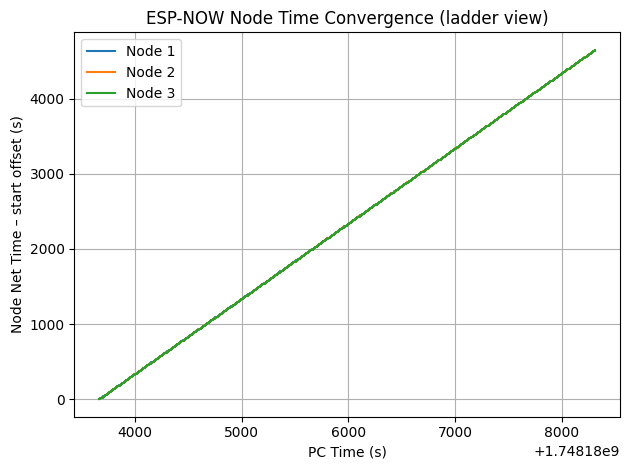

In [106]:
import matplotlib.pyplot as plt

for node_data, label in [(node1, "Node 1"),
                         (node2, "Node 2"),
                         (node3, "Node 3")]:
    times, net_times = zip(*[(x[0], x[1]) for x in node_data])
    deltas = [net - net_times[0] for net in net_times]      # or times[0] if you prefer
    plt.step(times, deltas, where='post', label=label)      # ← ladder plot

plt.xlabel("PC Time (s)")
plt.ylabel("Node Net Time – start offset (s)")
plt.title("ESP-NOW Node Time Convergence (ladder view)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


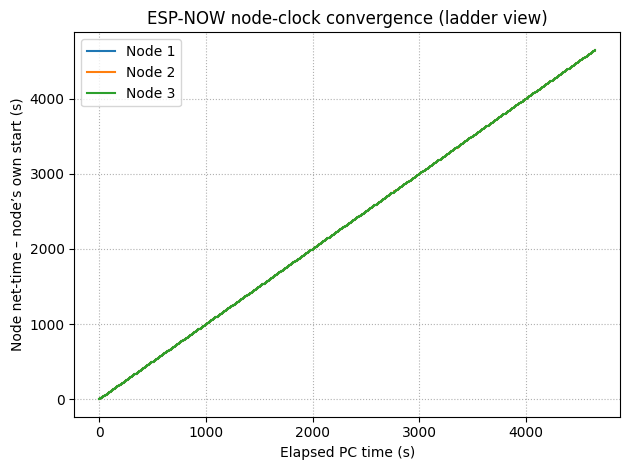

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# helper that converts a list like node1  ->  two aligned numpy arrays
# ------------------------------------------------------------------
def unpack(node_data):
    pc, nt, _ = zip(*node_data)          # ignore the 3rd field ("nodeX")
    pc = np.array(pc)
    nt = np.array(nt)

    # shift so both axes start at 0 for this node
    return pc - pc[0], nt - nt[0]

pc1, nt1 = unpack(node1)
pc2, nt2 = unpack(node2)
pc3, nt3 = unpack(node3)

# ------------------------------------------------------------------
# ladder plot
# ------------------------------------------------------------------
plt.step(pc1, nt1, where='post', label="Node 1")
plt.step(pc2, nt2, where='post', label="Node 2")
plt.step(pc3, nt3, where='post', label="Node 3")

plt.xlabel("Elapsed PC time (s)")
plt.ylabel("Node net-time – node’s own start (s)")
plt.title("ESP-NOW node-clock convergence (ladder view)")
plt.grid(True, ls=":")
plt.legend()
plt.tight_layout()
plt.show()


In [108]:
def print_interval_stats(node_data, node_name):
    if len(node_data) < 2:
        print(f"{node_name}: Not enough data")
        return

    intervals = [t2[0] - t1[0] for t1, t2 in zip(node_data[:-1], node_data[1:])]
    avg = sum(intervals) / len(intervals)
    std = (sum((x - avg)**2 for x in intervals) / len(intervals))**0.5
    print(f"{node_name}:")
    print(f"  Samples         : {len(intervals) + 1}")
    print(f"  Avg Interval    : {avg:.3f} s")
    print(f"  Interval StdDev : {std:.3f} s")
    print(f"  Min/Max         : {min(intervals):.3f} s / {max(intervals):.3f} s")


In [109]:
print_interval_stats(node1, "Node 1")
print_interval_stats(node2, "Node 2")
print_interval_stats(node3, "Node 3")


Node 1:
  Samples         : 275
  Avg Interval    : 10.000 s
  Interval StdDev : 0.000 s
  Min/Max         : 10.000 s / 10.001 s
Node 2:
  Samples         : 466
  Avg Interval    : 10.000 s
  Interval StdDev : 0.000 s
  Min/Max         : 9.999 s / 10.001 s
Node 3:
  Samples         : 466
  Avg Interval    : 10.000 s
  Interval StdDev : 0.000 s
  Min/Max         : 9.999 s / 10.001 s
